In [1]:
from itertools import product, combinations, repeat
import math
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from Levenshtein import distance
import torch
from plotnine import *
import magicsoup as ms
from magicsoup.examples.wood_ljungdahl import CHEMISTRY, MOLECULES, REACTIONS

theme_set(theme_minimal())

RUN_NAME = "2023-12-21_10-31"
RUN_DIR = Path("..") / "example" / "runs" / RUN_NAME

In [2]:
world = ms.World.from_file(rundir=RUN_DIR, device="cpu")
steps = sorted(int(d.name.split("step=")[1]) for d in RUN_DIR.glob("step=*"))
print(f"{len(steps)} steps from step {steps[0]} to step {steps[-1]}")

1000 steps from step 0 to step 4995


In [3]:
cell_records = []
mol_records = []
for step in steps:
    world.load_state(statedir=RUN_DIR / f"step={step}", ignore_cell_params=True)
    cell_records.append({ "step": step, "cells": world.n_cells })
    for mol in world.chemistry.molecules:
        mol_i = world.chemistry.mol_2_idx[mol]
        mol_records.append({
            "step": step,
            "molname": mol.name,
            "avg": world.molecule_map[mol_i].mean().item()
        })

cells_df = pd.DataFrame.from_records(cell_records)
mols_df = pd.DataFrame.from_records(mol_records)

In [6]:
def plot_timeseries(
        mols_df: pd.DataFrame,
        cells_df: pd.DataFrame,
        color_map: dict | None = None,
        alpha_map: dict | None = None,
        size_map: dict | None = None,
        text_offset_map: dict | None = None,
        marker_offset_map: dict | None = None,
        vline: float | None = None,
        marker_len=0.15,
        legend_offset=0.02,
        figsize=(9, 4),
        marker_size=2,
        text_size=7,
    ) -> ggplot:
    if color_map is None:
        color_map = {
            "cells": "#9494DE",
            "energy": "#FFB34D",
            "metabolite": "#747474"
        }
    if alpha_map is None:
        alpha_map = {
            "cells": 1.0,
            "energy": 1.0,
            "metabolite": 0.5
        }
    if size_map is None:
        size_map = {
            "cells": 1.0,
            "energy": 1.0,
            "metabolite": 0.5
        }
    if text_offset_map is None:
        text_offset_map = {
            "cells": 0.5,
            "energy": 0.35,
            "metabolite": 0.85,
        }
    if marker_offset_map is None:
        marker_offset_map = {
            "cells": 0.25,
            "energy": 0.05,
            "metabolite": 0.5,
        }


    mols_df["grp"] = "metabolite"
    mols_df.loc[mols_df["molname"] == "ATP", "grp"] = "energy"
    mols_df["grp"] = pd.Categorical(mols_df["grp"], ["energy", "metabolite"])
    mols_df["df"] = "B"
    cells_df["grp"] = "cells"
    cells_df["df"] = "A"


    legend_x = cells_df["step"].max() * (1 + legend_offset)
    ymax_cells = cells_df["cells"].max()
    ymax_mols = mols_df["avg"].max()

    start_cells = marker_offset_map["cells"] * ymax_cells
    end_cells = start_cells + marker_len * ymax_cells
    text_cells = text_offset_map["cells"] * ymax_cells

    start_energy = marker_offset_map["energy"] * ymax_mols
    end_energy = start_energy + marker_len * ymax_mols
    text_energy = text_offset_map["energy"] * ymax_mols

    legend_lines_df = pd.DataFrame.from_records([
        {"x": legend_x, "y": start_cells, "df": "A", "c": "cells"},
        {"x": legend_x, "y": end_cells, "df": "A", "c": "cells"},
        {"x": legend_x, "y": start_energy, "df": "B", "c": "energy"},
        {"x": legend_x, "y": end_energy, "df": "B", "c": "energy"},
    ])

    legend_text_df = pd.DataFrame.from_records([
        {"x": legend_x, "y": text_cells, "df": "A", "l": "cells"},
        {"x": legend_x, "y": text_energy, "df": "B", "l": "energy"},
    ])

    g = (ggplot()
        + geom_area(aes(x="step", y="cells", fill="grp"), data=cells_df)
        + geom_line(aes(x="step", y="avg", color="grp", alpha="grp", size="grp", group="molname"), data=mols_df)
        + geom_line(aes(x="x", y="y", color="c"), size=marker_size, data=legend_lines_df)
        + geom_text(aes(x="x", y="y", label="l"), size=text_size, angle=-90, data=legend_text_df)
        + facet_grid("df ~ .", scales="free_y")
        + scale_fill_manual(color_map, drop=False)
        + scale_color_manual(color_map, drop=False)
        + scale_alpha_manual(alpha_map, drop=False)
        + scale_size_manual(size_map, drop=False)
        + theme(strip_background=element_blank(), strip_text_y=element_blank())
        + theme(legend_position="none")
        + theme(axis_title=element_blank(), axis_text=element_blank())
        + theme(figure_size=figsize))
    if vline is not None:
        g = g + geom_vline(xintercept=vline, linetype="dashed", color="gray")
    return g

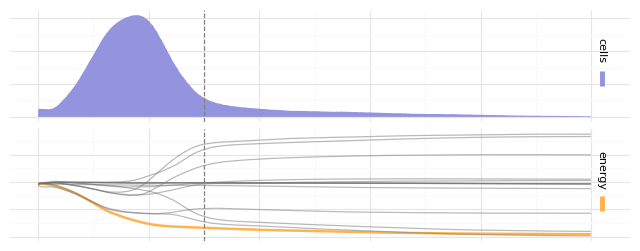

<ggplot: (8760857634513)>

In [7]:
text_offset_map = {"cells": 0.65, "energy": 0.65}
marker_offset_map = {"cells": 0.3, "energy": 0.25}
plot_timeseries(
    text_offset_map=text_offset_map,
    marker_offset_map=marker_offset_map,
    vline=1500,
    mols_df=mols_df,
    cells_df=cells_df,
    figsize=(8, 3),
    text_size=8
)

In [85]:
plot = plot_timeseries(
    text_offset_map=text_offset_map,
    marker_offset_map=marker_offset_map,
    vline=1500,
    mols_df=mols_df,
    cells_df=cells_df,
    figsize=(8, 3),
    text_size=8
)
plot.save("image.png", width=8, height=3, dpi=200)

/home/marc/anaconda3/envs/magicsoup_dev/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 3 in image.
/home/marc/anaconda3/envs/magicsoup_dev/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: image.png


In [67]:
top_n = 3
at_step = 1000

world.load_state(statedir=RUN_DIR / f"step={at_step}", ignore_cell_params=True)
top_labels = {f"CL{i}": d[0] for i, d in enumerate(Counter(world.cell_labels).most_common(n=top_n))}

cellmap_records = []
for step in steps:
    world.load_state(statedir=RUN_DIR / f"step={step}", ignore_cell_params=True)
    for cell_i in range(world.n_cells):
        x, y = world.cell_positions[cell_i].tolist()
        label = world.cell_labels[cell_i]
        genome = world.cell_genomes[cell_i]
        cellmap_records.append({"step": step, "x": x, "y": y, "label": label})

all_df = pd.DataFrame.from_records(cellmap_records)
all_df["grp"] = "all"

dfs = []
for name, label in top_labels.items():
    df = all_df[all_df["label"] == label].copy()
    df["grp"] = name
    dfs.append(df)

cellmap_df = pd.concat([all_df] + dfs, ignore_index=True)
cellmap_df["grp"] = pd.Categorical(cellmap_df["grp"], ["all"] + sorted(top_labels))

In [75]:
def plot_cellmaps(df: pd.DataFrame, color_map: dict | None = None, text_pad: dict | None = None, figsize=(8, 2), text_size=10) -> ggplot:
    if text_pad is None:
        text_pad = {"x": 0.05, "y": 0.03}
    if color_map is None:
        color_map = {
            "all": "dimgray",
            "CL0": "#35AF7B",
            "CL1": "#3976A4",
            "CL2": "#8860C4",
        }

    textx = world.map_size * (1 - text_pad["x"])
    texty = world.map_size * (1 - text_pad["y"])

    text_df = pd.DataFrame.from_records([
        {"x": textx, "y": texty, "grp": d}
        for d in color_map.keys()
    ])
    text_df["grp"] = pd.Categorical(text_df["grp"], color_map)

    axis_lims = (0, world.map_size)
    return (ggplot(df, aes(x="x", y="y"))
        + geom_point(aes(color="grp"), size=.1)
        + coord_fixed(ratio=1, xlim=axis_lims, ylim=axis_lims)
        + scale_color_manual(color_map, drop=False)
        + geom_text(aes(label="grp"), size=text_size, data=text_df)
        + facet_grid(". ~ grp")
        + theme(legend_position="none")
        + theme(strip_background=element_blank(), strip_text=element_blank())
        + theme(plot_margin=0, panel_spacing=0)
        + theme(panel_background=element_rect(fill="white"), panel_border=element_rect(colour="black", size=1))
        + theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank())
        + theme(axis_title=element_blank(), axis_text=element_blank())
        + theme(figure_size=figsize))

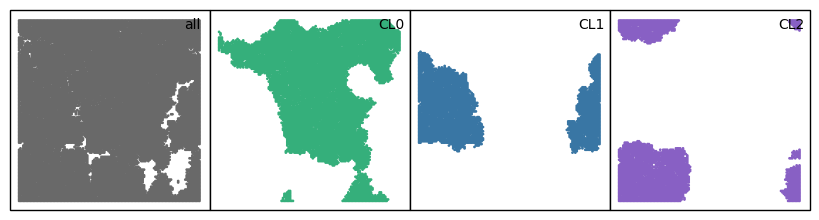

<ggplot: (8754830112645)>

In [80]:
color_map = {
    "all": "dimgray",
    "CL0": "#35AF7B",
    "CL1": "#3976A4",
    "CL2": "#8860C4",
}
plot_cellmaps(
    df=cellmap_df[cellmap_df["step"] == 800],
    color_map=color_map,
    figsize=(8, 2),
    text_size=10
)

In [81]:
plot = plot_cellmaps(
    df=cellmap_df[cellmap_df["step"] == 800],
    color_map=color_map,
    figsize=(8, 2),
    text_size=10
)
plot.save("image.png", width=8, height=2, dpi=200)

/home/marc/anaconda3/envs/magicsoup_dev/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 2 in image.
/home/marc/anaconda3/envs/magicsoup_dev/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: image.png
